In [39]:
# 🧱 Built-in
import re
import string
import unicodedata
import numpy as np

# 📊 Data processing
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold

# 📚 NLP
import nltk
from nltk.corpus import stopwords

# 🔥 PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from torch.optim import AdamW  # 👈 אם זה לא עובד, שנה ל: from transformers.optimization import AdamW

# 🤗 Transformers
from transformers import (
    BertTokenizerFast,
    BertModel,
    BertForTokenClassification,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)

# 📈 Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud

# הורדת stopwords (פעם אחת בלבד)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Loading the train & test data
train_df = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test_df = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")

In [4]:
# Our data size
print(train_df.shape)
print(test_df.shape)

(27481, 4)
(3534, 3)


In [5]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [7]:
#Missing values in training set
print("Train's nulls values\n",train_df.isnull().sum())

#Missing values in test set
print("\nTest's nulls values\n",test_df.isnull().sum())

Train's nulls values
 textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Test's nulls values
 textID       0
text         0
sentiment    0
dtype: int64


In [8]:
# Dropping rows with null values
train_df = train_df.dropna().reset_index(drop=True)

In [9]:
# checking the sentiment balnace
train_df['sentiment'].value_counts()

sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64

In [10]:
train_df['sentiment'].value_counts(normalize=True)

sentiment
neutral     0.404549
positive    0.312300
negative    0.283151
Name: proportion, dtype: float64

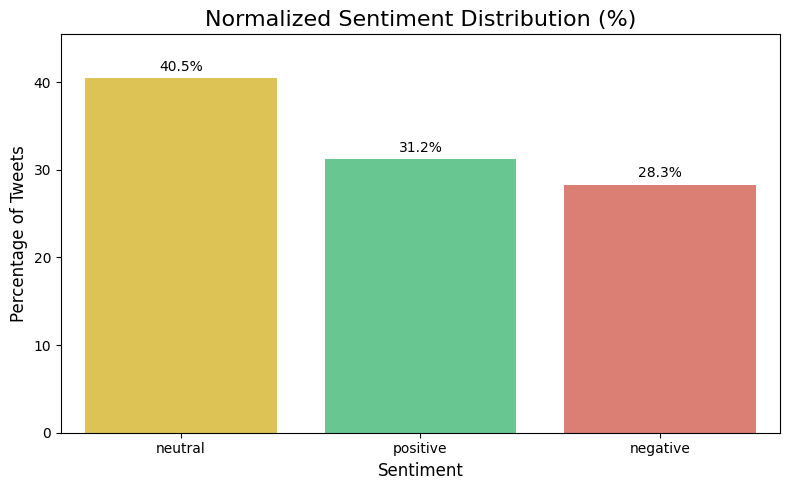

In [11]:
# חישוב ערכים מנורמלים
sentiment_counts = train_df['sentiment'].value_counts(normalize=True)

# הכפלה ב-100 כדי להציג באחוזים
sentiment_percentages = sentiment_counts * 100

# ציור הגרף
plt.figure(figsize=(8, 5))
colors = ['#F4D03F', '#58D68D', '#EC7063']

sns.barplot(
    x=sentiment_percentages.index,
    y=sentiment_percentages.values,
    palette=colors
)

# כותרות וצירים
plt.title('Normalized Sentiment Distribution (%)', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Percentage of Tweets', fontsize=12)

# תוויות עם אחוזים
for i, value in enumerate(sentiment_percentages.values):
    plt.text(i, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(sentiment_percentages.values) + 5)
plt.tight_layout()
plt.show()

In [12]:
# checking the sentiment balnace
test_df['sentiment'].value_counts()

sentiment
neutral     1430
positive    1103
negative    1001
Name: count, dtype: int64

In [13]:
test_df['sentiment'].value_counts(normalize=True)

sentiment
neutral     0.404641
positive    0.312111
negative    0.283248
Name: proportion, dtype: float64

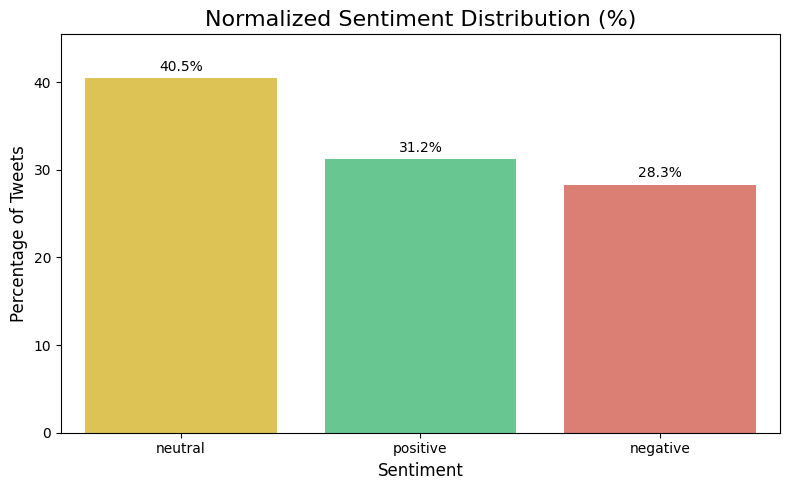

In [14]:
# חישוב ערכים מנורמלים
sentiment_counts = test_df['sentiment'].value_counts(normalize=True)

# הכפלה ב-100 כדי להציג באחוזים
sentiment_percentages = sentiment_counts * 100

# ציור הגרף
plt.figure(figsize=(8, 5))
colors = ['#F4D03F', '#58D68D', '#EC7063']

sns.barplot(
    x=sentiment_percentages.index,
    y=sentiment_percentages.values,
    palette=colors
)

# כותרות וצירים
plt.title('Normalized Sentiment Distribution (%)', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Percentage of Tweets', fontsize=12)

# תוויות עם אחוזים
for i, value in enumerate(sentiment_percentages.values):
    plt.text(i, value + 0.5, f'{value:.1f}%', ha='center', va='bottom', fontsize=10)

plt.ylim(0, max(sentiment_percentages.values) + 5)
plt.tight_layout()
plt.show()

In [15]:
# cleaning the text from sign, etc.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # הסרת לינקים
    text = re.sub(r'<.*?>+', '', text)  # הסרת תגיות HTML
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # ניקוי סימני פיסוק
    text = re.sub('\n', ' ', text)  # הסרת שורות חדשות
    text = re.sub(r'\w*\d\w*', '', text)  # מילים עם מספרים
    return text

def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

In [16]:
# cleaning train_df
train_text_cleaned = []
for text in train_df['text']:
    if isinstance(text, str):  
        clean = text_preprocessing(text)
        train_text_cleaned.append(clean)
    else:
        train_text_cleaned.append("")

train_df['clean_text'] = train_text_cleaned

In [17]:
# cleaning test_df
test_text_cleaned = []
for text in test_df['text']:
    if isinstance(text, str):
        clean = text_preprocessing(text)
        test_text_cleaned.append(clean)
    else:
        test_text_cleaned.append("")

test_df['clean_text'] = test_text_cleaned

In [18]:
# אורך במונחי תווים
train_df['text_len_chars'] = train_df['clean_text'].astype(str).apply(len)

# אורך במונחי מילים
train_df['text_len_words'] = train_df['clean_text'].astype(str).apply(lambda x: len(x.split()))


In [19]:
train_df

,textID,text,selected_text,sentiment,clean_text,text_len_chars,text_len_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,id have responded if i were going,33,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,sooo sad i will miss you here in san diego,42,10
2,088c60f138,my boss is bullying me...,bullying me,negative,my boss is bullying me,22,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,what interview leave me alone,29,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,sons of why couldnt they put them on the relea...,67,13
...,...,...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,wish we could come see u on denver husband los...,74,16
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,ive wondered about rake to the client has made...,112,23
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,yay good for both of you enjoy the break you p...,106,21
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,but it was worth it,19,5


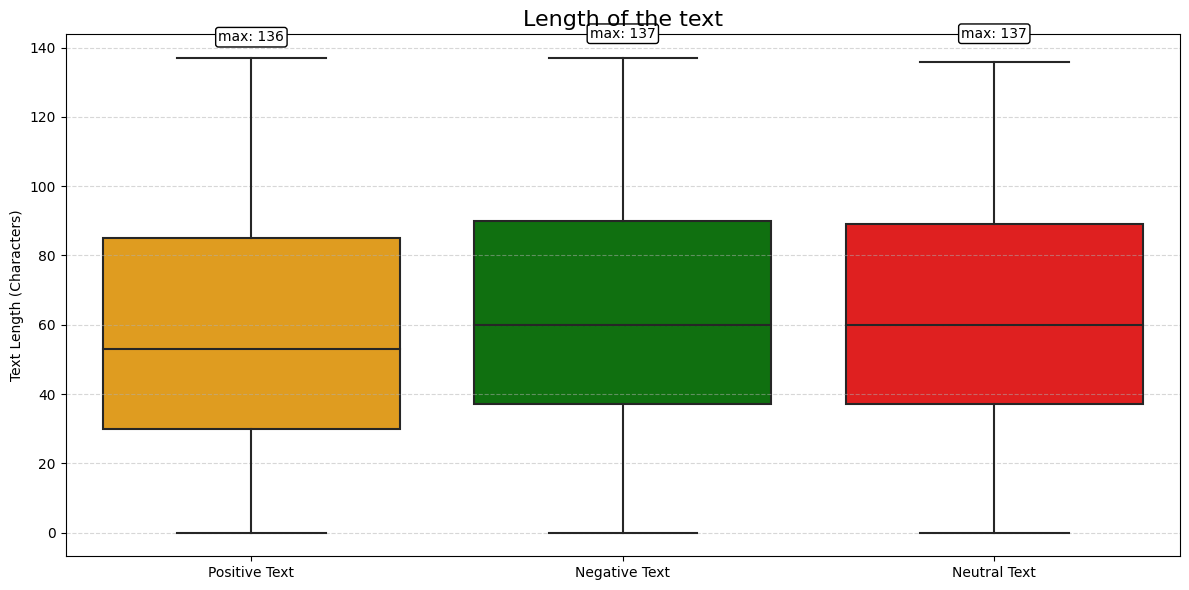

In [20]:
# צבעים לכל סוג סנטימנט
colors = {
    'positive': 'red',
    'negative': 'green',
    'neutral': 'orange'
}

# יצירת הגרף
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=train_df, x='sentiment', y='text_len_chars', palette=colors)

# כותרת
plt.title('Length of the text', fontsize=16)

# שמות קריאים יותר לציר X
sentiment_names = {
    'positive': 'Positive Text',
    'negative': 'Negative Text',
    'neutral': 'Neutral Text'
}

# הוספת הערך המקסימלי בלבד מעל כל תיבה
for i, sentiment in enumerate(['positive', 'negative', 'neutral']):
    max_val = train_df[train_df['sentiment'] == sentiment]['text_len_chars'].max()
    ax.text(i, max_val + 5,  # תוספת קטנה למיקום מעל הקופסה
            f"max: {max_val}",
            ha='center', va='bottom',
            fontsize=10,
            color='black',
            bbox=dict(boxstyle="round,pad=0.2", fc='white', ec='black', lw=1))

# עיצוב ציר X
plt.xticks(ticks=[0, 1, 2],
           labels=[sentiment_names[s] for s in ['positive', 'negative', 'neutral']])

# עיצוב כללי
plt.xlabel('')
plt.ylabel('Text Length (Characters)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [21]:
# Jaccard function for measuring the accuracy
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    if len(a) == 0 and len(b) == 0:
        return 1.0
    denominator = len(a) + len(b) - len(c)
    if denominator == 0:
        return 0.0
    return float(len(c)) / denominator

In [ ]:

sen_1 = "I absolutely love relaxing on the beach during bright sunny days."
sen_2 = "There's nothing better than spending a sunny day by the sea."
sen_3 = "Relaxing at the beach is the perfect way to enjoy warm, sunny weather."



print(jaccard(sen_1, sen_2))
print(jaccard(sen_1, sen_3))
print(jaccard(sen_2, sen_3))

In [23]:
# Adding jaccard value for each row in train data
results_jaccard=[]

for ind,row in train_df.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [24]:
jaccard_df = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
train_df = train_df.merge(jaccard_df ,how='outer')

In [25]:
train_df

,textID,text,selected_text,sentiment,clean_text,text_len_chars,text_len_words,jaccard_score
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,really oh sorry yall lol,24,5,0.200000
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,beckett thanks so much,22,4,0.166667
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,youll be missed bring me back a keychain,40,8,0.222222
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,get lit i am,12,4,0.666667
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,good morning to you its so pretty outside today,47,9,0.181818
...,...,...,...,...,...,...,...,...
27475,1b54db957d,zoombezi bay was soooo fun!! buuuut my legs ar...,zoombezi bay was soooo fun!! buuuut my legs ar...,neutral,zoombezi bay was soooo fun buuuut my legs are ...,62,11,1.000000
27476,79a3f22848,{cont} that right their is why fake btches sho...,excite me,positive,cont that right their is why fake btches shoul...,106,21,0.105263
27477,a38b466046,~ Happy Star Wars Day.every one ~ ...may the ...,Happy Star Wars Day.every one,positive,happy star wars dayevery one may the fourth be...,55,11,0.416667
27478,cc4a151d1d,"ï¿½anisalovesu me too. I am so so upset,especi...","lovesu me too. I am so so upset,especially bec...",neutral,ï ½anisalovesu me too i am so so upsetespecial...,95,19,0.875000


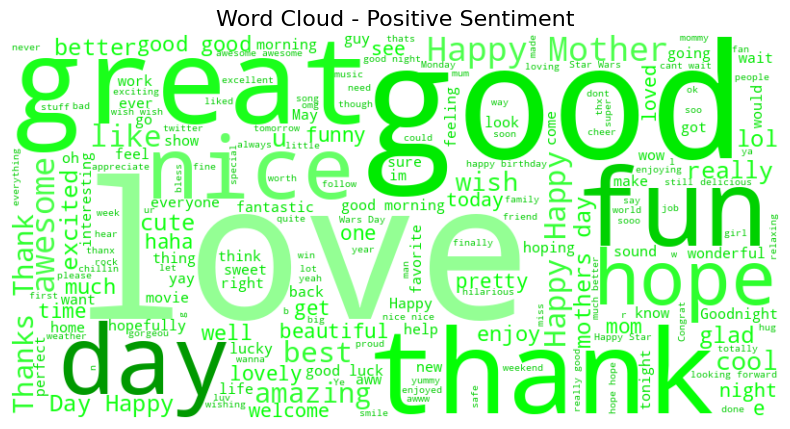

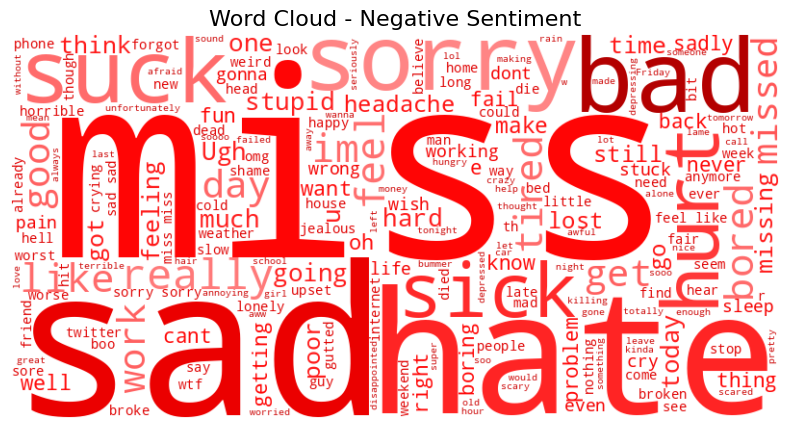

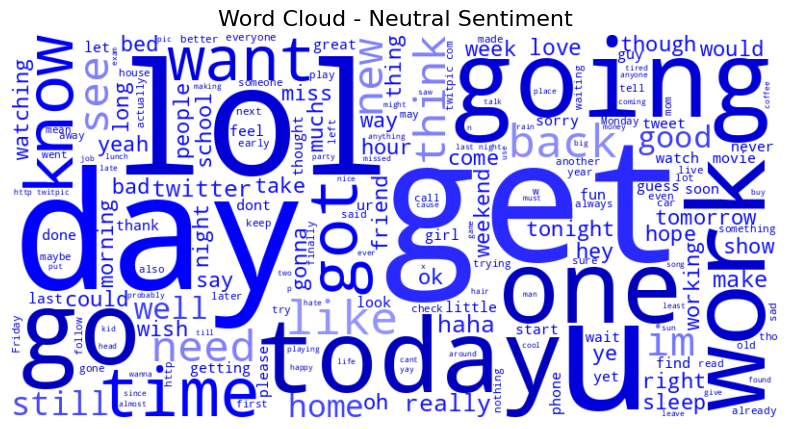

In [26]:
stop_words = set(stopwords.words('english'))

# פונקציית צביעה מותאמת אישית לפי צבע בסיס
def color_func_factory(base_color):
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        if base_color == 'green':
            return f"hsl(120, 100%, {30 + font_size % 50}%)"
        elif base_color == 'red':
            return f"hsl(0, 100%, {30 + font_size % 50}%)"
        elif base_color == 'blue':
            return f"hsl(240, 100%, {30 + font_size % 50}%)"
        else:
            return "black"
    return color_func

# פונקציה ליצירת ענן מילים עם צבע משתנה
def generate_wordcloud_by_sentiment(df, sentiment_label, base_color):
    text = ' '.join(df[df['sentiment'] == sentiment_label]['selected_text'].dropna())

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stop_words,
        max_words=200
    ).generate(text)

    # צבע מותאם לרגש
    color_func = color_func_factory(base_color)
    wordcloud.recolor(color_func=color_func)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud - {sentiment_label.capitalize()} Sentiment", fontsize=16)
    plt.axis('off')
    plt.show()

# יצירת עננים לפי רגשות
generate_wordcloud_by_sentiment(train_df, 'positive', 'green')
generate_wordcloud_by_sentiment(train_df, 'negative', 'red')
generate_wordcloud_by_sentiment(train_df, 'neutral',  'blue')


In [27]:
# Bert
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Encoding the text to numeric
def encode_text(text, sentiment, tokenizer, max_len=128):
    encoding = tokenizer.encode_plus(
        sentiment,
        text,
        add_special_tokens=True,
        return_offsets_mapping=True,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_len
    )
    return encoding

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
# Finding the sub-text  from text
def find_start_end(text, selected_text):
    start = text.find(selected_text)
    end = start + len(selected_text)
    return start, end

In [29]:
class TweetDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text = row.text
        selected_text = row.selected_text
        sentiment = row.sentiment

        # טוקניזציה תקינה: שומרת offset של text בלבד
        encoding = self.tokenizer.encode_plus(
            sentiment,
            text,
            add_special_tokens=True,
            return_offsets_mapping=True,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=self.max_len
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        offsets = encoding['offset_mapping'].squeeze()

        start_idx, end_idx = find_start_end(text, selected_text)

        target_start, target_end = 0, 0
        for i, (start, end) in enumerate(offsets):
            if start <= start_idx and end > start_idx:
                target_start = i
            if start < end_idx and end >= end_idx:
                target_end = i

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'start_positions': torch.tensor(target_start, dtype=torch.long),
            'end_positions': torch.tensor(target_end, dtype=torch.long)
        }


In [30]:
class TweetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 2)  # 2 כי start + end

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = self.dropout(outputs.last_hidden_state)
        logits = self.classifier(x)
        start_logits, end_logits = logits.split(1, dim=-1)
        return start_logits.squeeze(-1), end_logits.squeeze(-1)


In [31]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    return (start_loss + end_loss) / 2

In [32]:
train_df = train_df.dropna().reset_index(drop=True)

train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['sentiment'],
    random_state=42
)

# יצירת דאטהסטים עם הטוקנייזר
train_dataset = TweetDataset(train_data, tokenizer)
val_dataset = TweetDataset(val_data, tokenizer)

# יצירת דאטאלודרים עם סאמפלרים מתאימים
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=RandomSampler(train_dataset)  # לדגימה אקראית באימון
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    sampler=SequentialSampler(val_dataset)  # סדר קבוע בוולידציה
)

In [33]:
model = TweetModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_loader) * 3  # 3 epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [34]:
def train_epoch(model, data_loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_pos = batch['start_positions'].to(device)
        end_pos = batch['end_positions'].to(device)

        model.zero_grad()
        start_logits, end_logits = model(input_ids, attention_mask)
        loss = loss_fn(start_logits, end_logits, start_pos, end_pos)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
    return total_loss / len(data_loader)


In [35]:
def predict(model, tokenizer, test_df, device):
    model.eval()
    selected_texts = []

    for i in tqdm(range(len(test_df))):
        text = test_df.loc[i, 'text']
        sentiment = test_df.loc[i, 'sentiment']

        # השתמש באותו קידוד כמו באימון
        encoding = encode_text(text, sentiment, tokenizer)

        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)
        offset_mapping = encoding["offset_mapping"][0].cpu().numpy()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            start_logits, end_logits = outputs  # נניח שזה tuple

        start_idx = torch.argmax(start_logits, dim=1).item()
        end_idx = torch.argmax(end_logits, dim=1).item()

        if start_idx >= len(offset_mapping) or end_idx >= len(offset_mapping):
            selected_texts.append(text)
            continue

        if start_idx > end_idx:
            selected_texts.append(text)
        else:
            start_char = offset_mapping[start_idx][0]
            end_char = offset_mapping[end_idx][1]

            if start_char == 0 and end_char == 0:
                selected_texts.append(text)
            else:
                selected_text = text[start_char:end_char].strip()
                selected_texts.append(selected_text)

    return selected_texts


In [36]:
def evaluate(model, data_loader):
    model.eval()
    jaccard_scores = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_pos = batch['start_positions'].to(device)
            end_pos = batch['end_positions'].to(device)

            start_logits, end_logits = model(input_ids, attention_mask)
            start_preds = torch.argmax(start_logits, dim=1)
            end_preds = torch.argmax(end_logits, dim=1)

            for i in range(len(start_preds)):
                input_id = input_ids[i]
                tokens = tokenizer.convert_ids_to_tokens(input_id)
                pred_text = tokenizer.convert_tokens_to_string(tokens[start_preds[i]:end_preds[i]+1])
                true_text = tokenizer.convert_tokens_to_string(tokens[start_pos[i]:end_pos[i]+1])

                score = jaccard(pred_text, true_text)
                jaccard_scores.append(score)

    return sum(jaccard_scores) / len(jaccard_scores)


In [37]:
# מספר קיפולים
n_splits = 5

# חלוקה ל־Folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# אחסון תוצאות
all_val_jaccards = []
trained_models = []
val_loaders_per_fold = []

# חדש: שמירת היסטוריית לוס ו-Jaccard לכל קיפול
all_train_losses = []
all_val_jaccards_per_fold = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['sentiment'])):
    print(f"\n========== Fold {fold+1} / {n_splits} ==========")
    
    # חלוקת הדאטה
    train_data = train_df.iloc[train_idx].reset_index(drop=True)
    val_data = train_df.iloc[val_idx].reset_index(drop=True)
    
    # יצירת Dataset ו־DataLoader
    train_dataset = TweetDataset(train_data, tokenizer)
    val_dataset = TweetDataset(val_data, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    val_loaders_per_fold.append(val_loader)
    
    # אתחול מודל ואופטימייזר מחדש לכל Fold
    model = TweetModel()
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=3e-5)
    total_steps = len(train_loader) * 3  # 3 epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # לולאת אימון
    train_losses = []
    val_jaccards = []

    for epoch in range(5):
        print(f"\nEpoch {epoch + 1}")
        train_loss = train_epoch(model, train_loader, optimizer, scheduler)
        val_jaccard = evaluate(model, val_loader)

        train_losses.append(train_loss)
        val_jaccards.append(val_jaccard)

        print(f"Train Loss: {train_loss:.4f} | Validation Jaccard: {val_jaccard:.4f}")

    best_jaccard = max(val_jaccards)
    print(f"\n✅ Fold {fold+1} Finished. Best Jaccard: {best_jaccard:.4f}")

    # שמירה
    all_val_jaccards.append(best_jaccard)
    trained_models.append(model)
    all_train_losses.append(train_losses)
    all_val_jaccards_per_fold.append(val_jaccards)



========== Fold 1 / 5 ==========

Epoch 1


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.46it/s]


Train Loss: 1.0323 | Validation Jaccard: 0.7010

Epoch 2


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.43it/s]


Train Loss: 0.7620 | Validation Jaccard: 0.7044

Epoch 3


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.47it/s]


Train Loss: 0.6054 | Validation Jaccard: 0.7074

Epoch 4


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.50it/s]


Train Loss: 0.5305 | Validation Jaccard: 0.7074

Epoch 5


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.49it/s]


Train Loss: 0.5311 | Validation Jaccard: 0.7074

✅ Fold 1 Finished. Best Jaccard: 0.7074

========== Fold 2 / 5 ==========

Epoch 1


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.44it/s]


Train Loss: 1.0344 | Validation Jaccard: 0.6907

Epoch 2


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.43it/s]


Train Loss: 0.7638 | Validation Jaccard: 0.6969

Epoch 3


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.44it/s]


Train Loss: 0.6017 | Validation Jaccard: 0.6981

Epoch 4


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.49it/s]


Train Loss: 0.5315 | Validation Jaccard: 0.6981

Epoch 5


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.47it/s]


Train Loss: 0.5293 | Validation Jaccard: 0.6981

✅ Fold 2 Finished. Best Jaccard: 0.6981

========== Fold 3 / 5 ==========

Epoch 1


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.50it/s]


Train Loss: 1.0408 | Validation Jaccard: 0.6985

Epoch 2


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.52it/s]


Train Loss: 0.7643 | Validation Jaccard: 0.7017

Epoch 3


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.51it/s]


Train Loss: 0.6031 | Validation Jaccard: 0.7018

Epoch 4


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.48it/s]


Train Loss: 0.5334 | Validation Jaccard: 0.7018

Epoch 5


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.51it/s]


Train Loss: 0.5315 | Validation Jaccard: 0.7018

✅ Fold 3 Finished. Best Jaccard: 0.7018

========== Fold 4 / 5 ==========

Epoch 1


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.52it/s]


Train Loss: 1.0234 | Validation Jaccard: 0.6935

Epoch 2


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.51it/s]


Train Loss: 0.7540 | Validation Jaccard: 0.7023

Epoch 3


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.49it/s]


Train Loss: 0.5958 | Validation Jaccard: 0.6997

Epoch 4


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.54it/s]


Train Loss: 0.5235 | Validation Jaccard: 0.6997

Epoch 5


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.44it/s]


Train Loss: 0.5238 | Validation Jaccard: 0.6997

✅ Fold 4 Finished. Best Jaccard: 0.7023

========== Fold 5 / 5 ==========

Epoch 1


Evaluating: 100%|██████████| 344/344 [00:46<00:00,  7.43it/s]


Train Loss: 1.0156 | Validation Jaccard: 0.6965

Epoch 2


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.51it/s]


Train Loss: 0.5867 | Validation Jaccard: 0.6993

Epoch 4


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.50it/s]


Train Loss: 0.5174 | Validation Jaccard: 0.6993

Epoch 5


Evaluating: 100%|██████████| 344/344 [00:45<00:00,  7.50it/s]


Train Loss: 0.5189 | Validation Jaccard: 0.6993

✅ Fold 5 Finished. Best Jaccard: 0.6996

======== Cross Validation Summary ========
Jaccard Scores per Fold: [0.7074215066645222, 0.6980916540614075, 0.7018489750538334, 0.7023449549771108, 0.6995905115186786]


NameError: name 'np' is not defined

In [40]:
# === סיכום ===
print("\n======== Cross Validation Summary ========")
print(f"Jaccard Scores per Fold: {all_val_jaccards}")
print(f"Mean Jaccard: {np.mean(all_val_jaccards):.4f} | Std: {np.std(all_val_jaccards):.4f}")


======== Cross Validation Summary ========
Jaccard Scores per Fold: [0.7074215066645222, 0.6980916540614075, 0.7018489750538334, 0.7023449549771108, 0.6995905115186786]
Mean Jaccard: 0.7019 | Std: 0.0032


In [ ]:
# === מציאת הקיפול הכי טוב ===
best_fold = np.argmax([max(j) for j in all_val_jaccards_per_fold])
print(f"\n📈 הקיפול עם Jaccard הכי גבוה: Fold {best_fold + 1}")

In [41]:
# קריאת קבצי הטסט וההגשה לדוגמה
test_df = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
sample_submission = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")

# יצירת תחזיות
predictions = predict(model, tokenizer, test_df, device)

# עדכון העמודה בקובץ ההגשה
sample_submission["selected_text"] = predictions

# שמירת הקובץ
sample_submission.to_csv("submission.csv", index=False)
print("File created successfully: submission.csv")


100%|██████████| 3534/3534 [00:32<00:00, 108.99it/s]

File created successfully: submission.csv


In [42]:
sample_submission.head(10)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting (precisely -- skyscrapers galore). Go...
2,eee518ae67,such a shame!
3,01082688c6,happy
4,33987a8ee5,I like it!!
5,726e501993,that`s great!
6,261932614e,HATES
7,afa11da83f,blocked
8,e64208b4ef,and within a short time of the last clue all o...
9,37bcad24ca,What did you get? My day is alright.. haven`t...


In [43]:
val_predictions = predict(model, tokenizer, val_data.reset_index(drop=True), device)


100%|██████████| 5496/5496 [00:50<00:00, 108.87it/s]


In [44]:
val_data = val_data.reset_index(drop=True)

total_score = 0.0
for i in range(len(val_data)):
    true_text = val_data.loc[i, 'selected_text']
    pred_text = val_predictions[i]
    total_score += jaccard(true_text, pred_text)

average_jaccard = total_score / len(val_data)
print(f'Jaccard Score on validation set: {average_jaccard:.4f}')


Jaccard Score on validation set: 0.6977


In [51]:
val_data['predicted_text'] = val_predictions

val_data['jaccard_score'] = val_data.apply(
    lambda row: jaccard(row['selected_text'], row['predicted_text']),
    axis=1
)

val_data[['textID', 'text', 'sentiment', 'selected_text', 'predicted_text', 'jaccard_score']].head(10)


,textID,text,sentiment,selected_text,predicted_text,jaccard_score
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,negative,sorry,sorry,1.000000
1,8106d4c6fa,_beckett Thanks so much !,positive,beckett Thanks,Thanks so much !,0.200000
2,a088ac278e,I LOVE YOU GUYS! get your **** to austral...,positive,I LO,I LOVE YOU GUYS!,0.200000
3,ceec78ede2,Soooooooo What Happened To Power ForReal?,neutral,Soooooooo What Happened To Power ForRea,Soooooooo What Happened To Power ForReal?,0.714286
4,9707b0fc9a,Now I feel left out... All alone in AZ...lol,neutral,Now I feel left out... All alone in AZ...,Now I feel left out... All alone in AZ...lol,0.800000
5,c62590abcd,"Shiv, his place, slowly I hope",positive,y I ho,I hope,0.250000
6,3e4fbcd114,You guys can make it through!,neutral,You guys can make it through,You guys can make it through!,0.714286
7,6f7127d9d7,All this flirting going on - The ATG smiles...,neutral,All this flirting going on - The ATG smiles. Y...,All this flirting going on - The ATG smiles. Y...,0.833333
8,bd085c659b,G`night!,neutral,G`night,G`night!,0.000000
9,c899c9553f,Is it me (my machine)? or... Vids freeze up...,neutral,"Is it me (my machine)? or... Vids freeze up, h...","Is it me (my machine)? or... Vids freeze up, h...",0.866667


In [54]:
specific_id = "a088ac278e"
row = val_data[val_data['textID'] == specific_id]
if not row.empty:
    print("text:", row.iloc[0]['text'])
    print("\nsentiment:", row.iloc[0]['sentiment'])
    print("\nselected_text:", row.iloc[0]['selected_text'])
    print("\npredicted_text:", row.iloc[0]['predicted_text'])
    print("\nJaccard:", jaccard(row.iloc[0]['selected_text'], row.iloc[0]['predicted_text']))
else:
    print("id not found")


text:      I LOVE YOU GUYS! get your **** to australia in december for my birthday

sentiment: positive

selected_text: I LO

predicted_text: I LOVE YOU GUYS!

Jaccard: 0.2


In [47]:
# === פונקציות גרפים ===
def plot_loss(train_losses):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label='Train Loss', marker='o', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_jaccard(val_jaccards):
    plt.figure(figsize=(6, 4))
    plt.plot(val_jaccards, label='Validation Jaccard', marker='x', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Jaccard Score')
    plt.title('Validation Jaccard over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

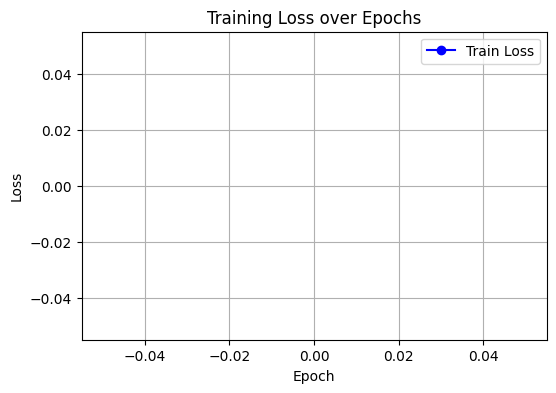

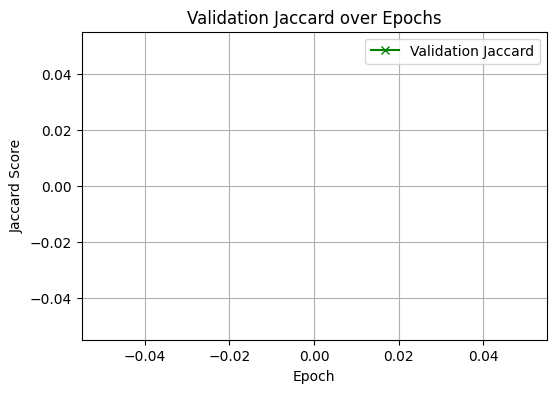

In [50]:
# === ציור גרפים לקיפול הכי טוב ===
plot_loss(all_train_losses[best_fold])
plot_jaccard(all_val_jaccards_per_fold[best_fold])